In [1]:
import numpy as np
import pandas as pd
import urllib
import os
import pylab as pl
import geopandas as gpd
#import choroplethNYC as cp
import requests
import json
import io
import shapely
from fiona.crs import from_epsg
import pysal as ps

%pylab inline

puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    puidata = os.getenv("PUIDATA")

Populating the interactive namespace from numpy and matplotlib


In [2]:
# download 201409 citibike data

#! curl -O https://s3.amazonaws.com/tripdata/201409-citibike-tripdata.zip
#! mv 201409-citibike-tripdata.zip $PUIDATA
#! unzip $PUIDATA/201409-citibike-tripdata.zip 
#! mv 201409-citibike-tripdata.csv $PUIDATA

In [3]:
df = pd.read_csv(os.getenv("PUIDATA") + '/201409-citibike-tripdata.csv')
df.head()

df['date'] = pd.to_datetime(df['starttime'])

In [4]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date
0,2828,9/1/2014 00:00:25,9/1/2014 00:47:33,386,Centre St & Worth St,40.714948,-74.002345,450,W 49 St & 8 Ave,40.762272,-73.987882,15941,Subscriber,1980.0,1,2014-09-01 00:00:25
1,368,9/1/2014 00:00:28,9/1/2014 00:06:36,387,Centre St & Chambers St,40.712733,-74.004607,2008,Little West St & 1 Pl,40.705693,-74.016777,18962,Subscriber,1982.0,1,2014-09-01 00:00:28
2,2201,9/1/2014 00:00:40,9/1/2014 00:37:21,386,Centre St & Worth St,40.714948,-74.002345,441,E 52 St & 2 Ave,40.756014,-73.967416,15982,Subscriber,1968.0,1,2014-09-01 00:00:40
3,322,9/1/2014 00:00:41,9/1/2014 00:06:03,167,E 39 St & 3 Ave,40.748901,-73.976049,528,2 Ave & E 31 St,40.742909,-73.977061,19081,Subscriber,1961.0,1,2014-09-01 00:00:41
4,1693,9/1/2014 00:00:59,9/1/2014 00:29:12,223,W 13 St & 7 Ave,40.737815,-73.999947,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,20836,Subscriber,1978.0,1,2014-09-01 00:00:59


In [5]:
df.drop(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'gender'], axis=1, inplace=True)

In [6]:
df['age'] = 2018 - df['birth year']
df.head()

,birth year,date,age
0,1980.0,2014-09-01 00:00:25,38.0
1,1982.0,2014-09-01 00:00:28,36.0
2,1968.0,2014-09-01 00:00:40,50.0
3,1961.0,2014-09-01 00:00:41,57.0
4,1978.0,2014-09-01 00:00:59,40.0


In [7]:
df.drop(['birth year'], axis=1, inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


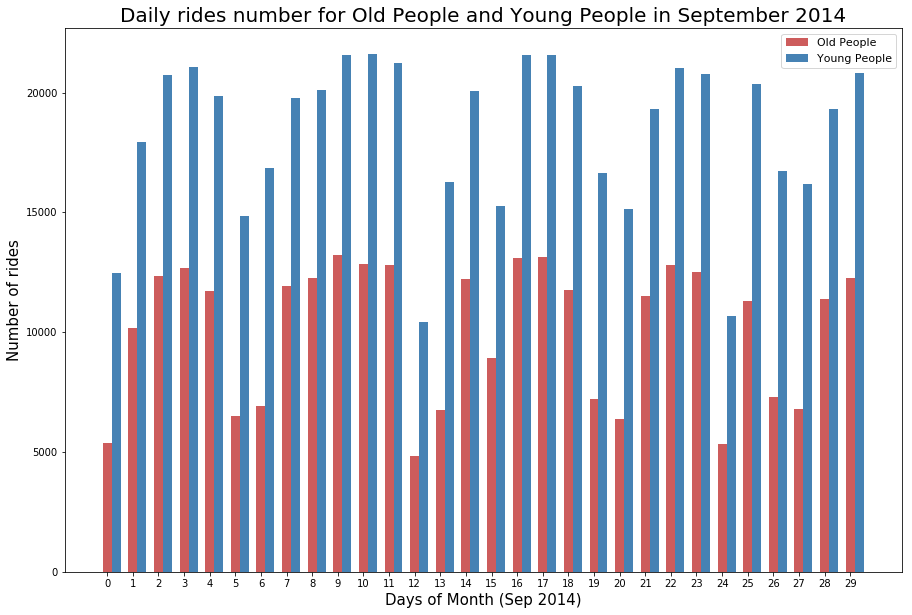

In [8]:
fig=pl.figure(figsize(15,10))
x = range(30)

counts_w = (df['date'][df['age'] >= 45].groupby([df['date'].dt.day]).count())
norm_w = 1

bar_width = 0.35


ax = pl.bar(left = x, height=counts_w, width = 0.35, label='Old People(age>=45)', color='IndianRed')


counts_m = (df['date'][df['age'] < 45].groupby([df['date'].dt.day]).count())
norm_m = 1
pl.bar(left = [i + bar_width for i in x], height=counts_m, width = 0.35, label='Young People(age<45)', color='SteelBlue')      


plt.xticks(x)
pl.ylabel ("Number of rides",fontsize=15)
pl.xlabel ("Days of Month (Sep 2014)",fontsize=15)
pl.title('Daily rides number for Old People and Young People in September 2014',fontsize=20)
pl.legend(['Old People','Young People'],fontsize=11)

plt.savefig("Daily_rides_number_for_Old_People_and_Young_People_in_201409.png")

# Figure 1

Here is the histogram about the number of old (age>=45) and young (age<45) people riding citi bike through 09.2014, which shows by days. I use this figure to find the difference between the number of old and young people riding citi bike. From this figure, we can see that the number of young people who ride citi bike in 09.2014 is much higher than the number of old people through the whole month.


## Improvement

Here I optimize the legend to prevent it to obscure the figure and add the age range. And use larger fontsize to make sure reader see the plot clearly. Change the title to 'Daily rides number for Old People and Young People in September 2014' and change the y-axis label to 'Days of Month (Sep 2014)'. What's more, I remove the error bar in case it leads some misunderstanding. And I make the bars for next to each other (not stacked) to compare their magnitude.